# Script to peform a simple Bayesian inference of mass and concetration from a Navarro-Frenk-White profile to a stack weak lensing data

The input it is a fit file with

- $R$ [Mpc], 
- $\Delta\Sigma$ [$M_{\odot} pc^2$], 
- $\Delta\Sigma_{err}$ [$M_{\odot} pc^2$].


The output are the "best" values for mass $(M_{200})$ and concentration $(c)$,
according to a simple Bayesian inference approach.

The script depends on the NFW.py module from joergdietrich (at Github):
https://github.com/joergdietrich/NFW/blob/master/nfw.py

In [56]:
#!/bin/env python
#==========================
# author: Maria Elidaiana
# email: mariaeli@cbpf.br
# Script based on: 
# https://github.com/drphilmarshall/StatisticalMethods/blob/b9f481876c002cb210375e07783d6515ed536cca/examples/Cepheids/PeriodMagnitudeRelation.ipynb
#==========================

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM  # The default cosmology is: astropy.cosmology.default_cosmology.get()
from scipy.stats import norm
from NFW.nfw import NFW

from astropy.table import Table, vstack      # Use tables instead of recarrays from fits

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [57]:
stacked_clusters = Table.read('./results2fit.fits')
print(stacked_clusters)                      # Check the data

    Radius     Delta_Sigma_T err_Delta_Sigma_T  Delta_Sigma_X  err_Delta_Sigma_X
-------------- ------------- ----------------- --------------- -----------------
           0.1  246.52071203 4.08296612449e-13  -11.4729797144 1.37407513805e-14
0.154445210495 215.447141102 9.42222951806e-14   11.6128278614 7.85185793171e-15
0.238533230447 161.881867782 3.45481748995e-13   1.45613472696 1.71759392256e-15
0.368403149864 111.271086535 1.41333442771e-13   1.73116596799 1.22685280183e-15
0.568981020276 72.6618871311 1.25629726907e-13  -2.41910383544 4.41667008659e-15
 0.87876393444 43.0357903427 7.06667213854e-14  -1.20318665571 1.96296448293e-15
  1.3572088083 24.2780721793 3.92592896586e-15 -0.298908004652 5.52083760824e-16
 2.09614400083 13.1988907615 3.92592896586e-15 -0.360660312642 6.74769041007e-16
 3.23739401435 7.09606075563  1.4722233622e-14 -0.064386478475 6.13426400915e-17
           5.0 4.19253390358 3.43518784512e-15 -0.313966440832 1.84027920275e-16


In [58]:
R     = np.array(stacked_clusters['Radius'])
DSobs = np.array(stacked_clusters['Delta_Sigma_T'])
DSerr = np.array(stacked_clusters['err_Delta_Sigma_T'])

z_mean = 0.4

In [59]:
# NFW module that compute the \Delta\Sigma from theory

def DStheo(R, m200,c):    
    nfw = NFW(m200, c, z_mean, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) # can change cosmology, overdensity...  
    ds  = nfw.delta_sigma(R)                                             # in units of solMass/Mpc^2
    return np.array(ds.value/1.e12)                                      # in units of solMass/pc^2

In [60]:
# Checking the model results for a cluster with m200=1e14 and c=4

print(DStheo(R, 1e14,4))

[ 259.52471646  211.94733291  160.59661701  112.42495269   72.89561347
   44.11066502   25.163018     13.67295773    7.14348346    3.61670299]


In [61]:
# Defining the likelihoods...

def log_likelihood(R, DSobs, DSerr, m200, c):
    return -0.5*np.sum(( DSobs - DStheo(R, m200,c) )**2/(DSerr**2))

def log_prior(m200,c):

    m200min, m200max = 1e12, 1e15   
    cmin, cmax = 4, 5       

    if (m200<m200min)|(m200>m200max):
        log_m200_prior = -np.inf
    else:
        log_m200_prior = -np.log(m200max-m200min)
        
    if (c<cmin)|(c>cmax):
        log_c_prior = -np.inf
    else:
        log_c_prior = -np.log(cmax-cmin)
        
    return log_m200_prior+log_c_prior
    
def log_posterior(R, DSobs, DSerr, m200, c):
    return log_likelihood(R, DSobs, DSerr, m200, c) + log_prior(m200, c)

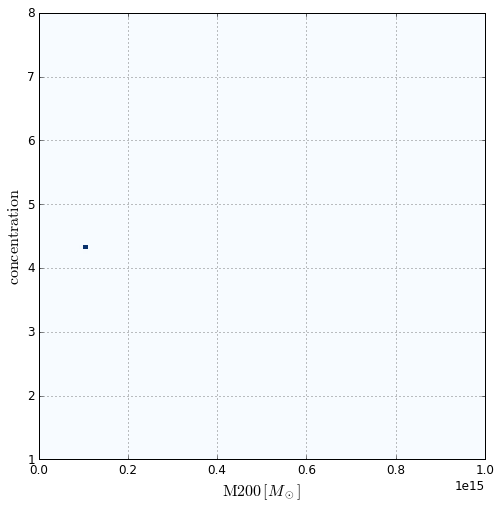

In [62]:
# Set up parameter grids:

npix = 100
m200min,m200max = 1e12, 1e15       
cmin,cmax = 1, 8                  
m200grid = np.linspace(m200min,m200max,npix)

cgrid = np.linspace(cmin,cmax,npix)
logprob = np.zeros([npix,npix])

# Loop over parameters, computing unormalized log posterior PDF:
for i,m200 in enumerate(m200grid):
    for j,c in enumerate(cgrid):
        logprob[j,i] = log_posterior(R,DSobs,DSerr,m200,c)
        
# Normalize and exponentiate to get posterior density:
Z = np.max(logprob)

prob = np.exp(logprob - Z)

norm = np.sum(prob)
prob /= norm        

sorted = np.sort(prob.flatten())
C = sorted.cumsum()

# Find the pixel values that lie at the levels that contain
# 68% and 95% of the probability:
lvl68 = np.min(sorted[C > (1.0 - 0.68)])
lvl95 = np.min(sorted[C > (1.0 - 0.95)])

plt.figure
fig = plt.figure(figsize=(8, 8))
plt.imshow(prob, origin='lower', cmap='Blues', interpolation='none', extent=[m200min,m200max,cmin,cmax], aspect='auto') 
try:
    plt.contour(prob,[lvl95,lvl68],colors='black',extent=[m200min,m200max,cmin,cmax], aspect='auto') 
except ValueError: # for nfwsim
    plt.contour(prob,[lvl68],colors='black',extent=[m200min,m200max,cmin,cmax], aspect='auto')
plt.grid()    
plt.xlabel(r'$ {\rm M200} \, [M_\odot]$', fontsize=16)
plt.ylabel(r'$ {\rm concentration} $', fontsize=16)
plt.show()

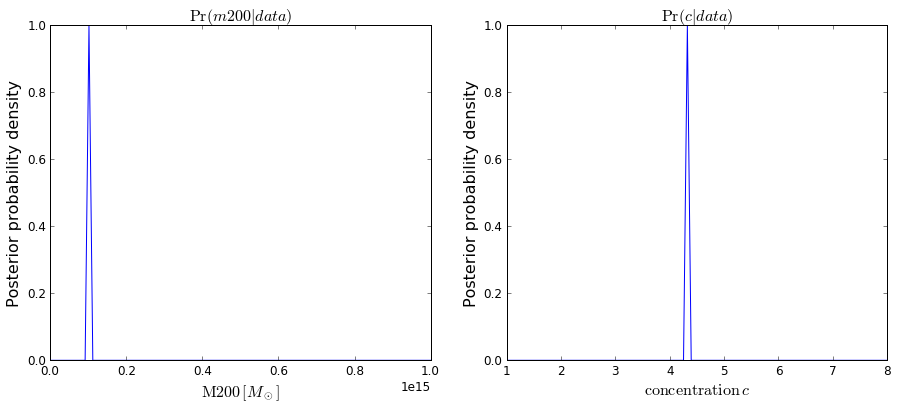

In [63]:
# Plot 1D distributions:

prob_m200_given_data = np.sum(prob,axis=0)
prob_c_given_data = np.sum(prob,axis=1)

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

left = ax[0].plot(m200grid, prob_m200_given_data)
ax[0].set_title(r'${\rm Pr}(m200|data)$', fontsize=16)
ax[0].set_xlabel(r'$ {\rm M200} \, [M_\odot]$', fontsize=16)
ax[0].set_ylabel('Posterior probability density', fontsize=16)

right = ax[1].plot(cgrid, prob_c_given_data)
ax[1].set_title(r'${\rm Pr}(c|data)$', fontsize=16)
ax[1].set_xlabel(r'$ {\rm concentration} \, c $', fontsize=16)
ax[1].set_ylabel('Posterior probability density', fontsize=16)
plt.show()

In [64]:
# Compress each PDF into a median and 68% credible interval, and report:

def compress_1D_pdf(x,pr,ci=68,dp=1):
    
    # Interpret credible interval request:
    low  = (1.0 - ci/100.0)/2.0    # 0.16 for ci=68
    high = 1.0 - low               # 0.84 for ci=68

    # Find cumulative distribution and compute percentiles:
    cumulant = pr.cumsum()
    pctlow = x[cumulant>low].min()
    median = x[cumulant>0.50].min()
    pcthigh = x[cumulant>high].min()
    
    # Convert to error bars, and format a string:
    errplus = np.abs(pcthigh - median)
    errminus = np.abs(median - pctlow)  

    report = "$ "+str(round(median,dp))+"^{+"+str(round(errplus,dp))+"}_{-"+str(round(errminus,dp))+"} $"

    return [report, median]

print("m200 = ",compress_1D_pdf(m200grid,prob_m200_given_data,ci=68,dp=2)[0])
print("c    = ",compress_1D_pdf(cgrid,prob_c_given_data,ci=68,dp=2)[0])

('m200 = ', '$ 1.01909090909e+14^{+0.0}_{-0.0} $')
('c    = ', '$ 4.32^{+0.0}_{-0.0} $')


In [65]:
# Plotting the results...

def plot(R,DS,DSe,DStheo, DStheo_bf, title, label1, label2, label3):
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(1, 1, 1, yscale='log')
    plt.errorbar(R, DS, yerr=DSe, mec='k', c='k', ls='none', marker='o', mfc='k', ms=5, label=label1)
    plt.plot(R, DStheo, 'r--', label=label2)
    plt.plot(R, DStheo_bf, 'g-', label=label3)
    plt.title(title,fontsize=16)
    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12)  
    plt.xlabel(r'$\mathrm{\mathsf{R\,[Mpc]}}$', fontsize=16)
    plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=16)
    #plt.ylim(0.1, 1000)
    #plt.xlim(0.01, 20)
    plt.legend(loc='best')  
    plt.show()  
    return

('Best values from bayesian inference:', 101909090909090.92, 4.3232323232323235)

('Reduced chi^2 from bayesian inference parameters:', 1.6012995713250529e+28)
('Reduced chi^2 from nfwsim parameters:', 8.0319106541285032e+27)


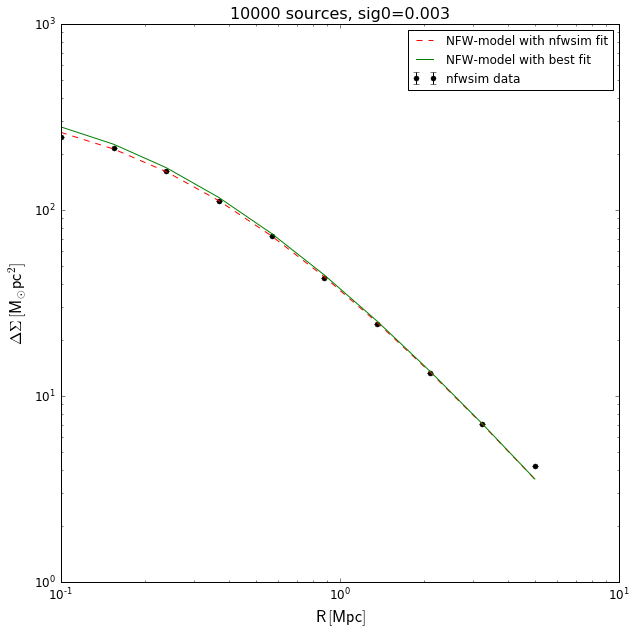

In [68]:
best_m200 = compress_1D_pdf(m200grid,prob_m200_given_data,ci=68,dp=2)[1]
best_c    = compress_1D_pdf(cgrid,prob_c_given_data,ci=68,dp=2)[1] 

print('Best values from bayesian inference:', best_m200,best_c)
print

chisq = ((-1./0.5)*log_likelihood(R, DSobs, DSerr, best_m200, best_c))/(len(R)-2.)
print('Reduced chi^2 from bayesian inference parameters:', chisq)

best_m200_nfw = 0.98728e14 # nfwsim with sig0=0.003
best_c_nfw    = 4.05270    # nfwsim with sig0=0.003

chisq_nfwsim = ((-1./0.5)*log_likelihood(R, DSobs, DSerr, best_m200_nfw, best_c_nfw))/(len(R)-2.)
print('Reduced chi^2 from nfwsim parameters:', chisq_nfwsim)

DStheo_fromsim = DStheo(R, best_m200_nfw, best_c_nfw) 
DStheo_fromfit = DStheo(R, best_m200,best_c)

plot(R,DSobs,DSerr, DStheo_fromsim, DStheo_fromfit, 
     '10000 sources, sig0=0.003', 'nfwsim data', 'NFW-model with nfwsim fit', 'NFW-model with best fit')
